In [6]:
import joblib
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from networkx.algorithms.centrality import eigenvector_centrality

from src.step_2_graph_python_occ import *

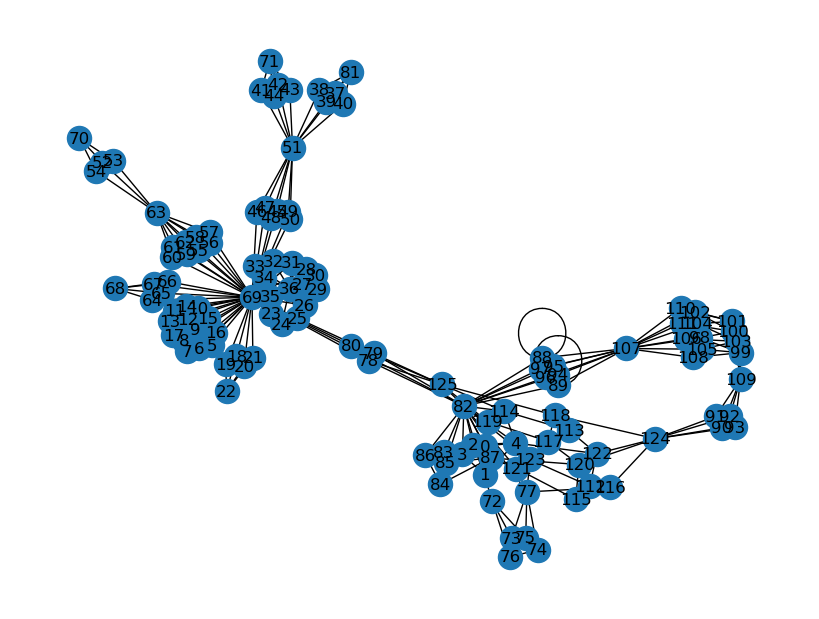

In [8]:
# {'123905_DE070000_A.graphml', '56431_KomRad.graphml'}
plt.figure(figsize=(8, 6))
shp, G = parse_step_with_occ(
    r"E:\gnn_data\step_files\23577_MLD_21_302_74.stp")
nx.draw(G, with_labels=True)
nx.write_graphml_lxml(G, r"E:\test_graph.graphml")
plt.savefig(r"E:\test_graph.png", format="png", dpi=300)

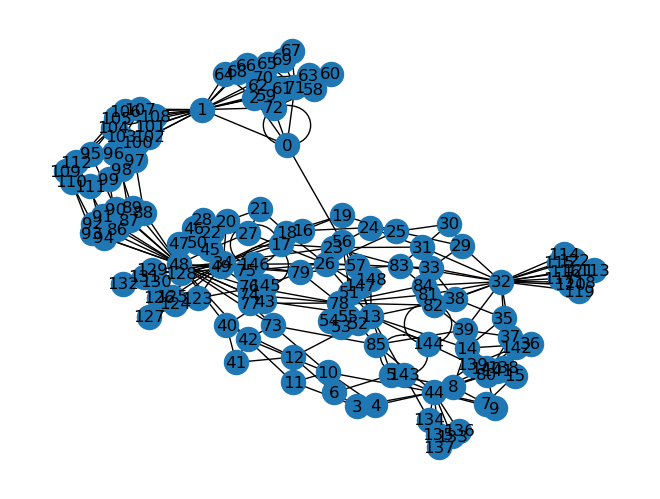

In [23]:
G = nx.read_graphml(r"E:\gnn_data\graphml_files\100075_Comp21.graphml")
nx.draw(G, with_labels=True)

In [24]:
G.number_of_nodes(), G.number_of_edges()
# for node in nodes:

(149, 365)

In [26]:
pagerank = nx.pagerank(G)
clusters = nx.clustering(G)
max(clusters.values())

0.6666666666666666

In [7]:
t = TopologyExplorer(shp)
all_faces = list(t.faces())
all_edges = list(t.edges())
all_vertices = list(t.vertices())
print(len(all_faces), len(all_edges), len(all_vertices))
all_face_properties = {}
for face in all_faces:
    face_prop = get_face_properties(face)
    for key in face_prop.keys():
        if key not in all_face_properties:
            all_face_properties[key] = []
        all_face_properties[key].append(face_prop[key])
pd.DataFrame(all_face_properties)

355 1065 1065


,surface_type,area,perimeter,edge_count,vertex_count,compactness,u_span,v_span,mean_curvature,gaussian_curvature,orientation
0,0,2.584023,7.789887,3,3,0.535111,2.567324,2.013009,0.0,0.0,0
1,0,2.514537,7.719666,3,3,0.530237,2.498288,2.013008,0.0,0.0,0
2,0,12.229418,26.481341,3,3,0.219147,12.152344,2.013008,-0.0,0.0,0
3,0,12.231383,26.483293,3,3,0.219150,12.152344,2.013008,0.0,0.0,0
4,0,174.198375,348.170115,3,3,0.018058,173.072700,2.013008,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
350,0,0.000664,0.141377,3,3,0.417318,0.023438,0.056641,0.0,0.0,0
351,0,1.137218,72.844130,3,3,0.002693,0.144531,36.390625,0.0,0.0,0
352,0,0.426457,72.805362,3,3,0.001011,0.167969,36.390625,0.0,0.0,0
353,0,0.001770,0.203489,3,3,0.537170,0.062501,0.056641,0.0,0.0,0


In [112]:
all_edge_properties = {}
for edge in all_edges:
    edge_prop = get_edge_properties(edge)
    for key in edge_prop.keys():
        if key not in all_edge_properties:
            all_edge_properties[key] = []
        all_edge_properties[key].append(edge_prop[key])
pd.DataFrame(all_edge_properties)

,length,curve_type,is_closed,chord_length,orientation
0,4.712389,1,False,4.242641,0
1,69.500000,0,False,69.500000,1
2,50.000000,0,False,50.000000,1
3,69.500000,0,False,69.500000,1
4,4.712389,1,False,4.242641,0
...,...,...,...,...,...
71,4.000000,0,False,4.000000,1
72,4.000000,0,False,4.000000,0
73,4.000000,0,False,4.000000,1
74,4.000000,0,False,4.000000,0


In [29]:
G = nx.read_graphml(r"E:\gnn_data\graphml_files_v2\56477_D148554_001.graphml")

In [3]:
with open(r"E:\gnn_data\pyg_data_v2\dataset_mapping.pkl", "rb") as f:
    dataset_mapping = joblib.load(f)
dataset_mapping["failed_files"]

[{'path': 'E:\\gnn_data\\graphml_files\\123905_DE070000_A.graphml',
  'error': "[Errno 2] No such file or directory: 'E:\\\\gnn_data\\\\graphml_files\\\\123905_DE070000_A.graphml'",
  'index': 14543},
 {'path': 'E:\\gnn_data\\graphml_files\\30405_WLL_BRCKT_231127_D.graphml',
  'error': 'expected sequence of length 19 at dim 1 (got 17)',
  'index': 20080},
 {'path': 'E:\\gnn_data\\graphml_files\\30801_WLL_BRCKT_231127_D.graphml',
  'error': 'expected sequence of length 19 at dim 1 (got 17)',
  'index': 20366},
 {'path': 'E:\\gnn_data\\graphml_files\\30807_WLL_BRCKT_231127_D.graphml',
  'error': 'expected sequence of length 19 at dim 1 (got 17)',
  'index': 20372},
 {'path': 'E:\\gnn_data\\graphml_files\\30811_WLL_BRCKT_231127_D.graphml',
  'error': 'expected sequence of length 19 at dim 1 (got 17)',
  'index': 20376},
 {'path': 'E:\\gnn_data\\graphml_files\\56431_KomRad.graphml',
  'error': "[Errno 2] No such file or directory: 'E:\\\\gnn_data\\\\graphml_files\\\\56431_KomRad.graphml'",

In [68]:
step_path = r"E:\gnn_data\step_files\101418_bottom.step"
step_path = r"E:\gnn_data\step_files\23567_A1033479_A.stp"
shape = read_step_file(step_path)

# Parse all faces
face_explorer = TopExp_Explorer(shape, TopAbs_FACE)
edge_to_faces = defaultdict(list)
face_list = []
face_index = 0
face_to_index = {}
face_properties = []
while face_explorer.More():
    face = face_explorer.Current()
    if face:
        face_list.append(face)
        face_to_index[face] = face_index
        face_index += 1
        face_properties.append(get_face_properties(face))
    face_explorer.Next()

edge_hash_to_edge = {}
edge_properties_dict = {}

# Parse all edges for each face
for face_idx, face in enumerate(face_list):
    edge_explorer = TopExp_Explorer(face, TopAbs_EDGE)
    while edge_explorer.More():
        edge = edge_explorer.Current()
        edge_hash = edge.__hash__()
        if edge_hash not in edge_hash_to_edge:
            edge_hash_to_edge[edge_hash] = edge
            # Extract edge properties once per unique edge
            edge_properties_dict[edge_hash] = get_edge_properties(edge)

        edge_to_faces[edge_hash].append((face_idx, edge))
        edge_explorer.Next()
G = nx.Graph()
for idx, (face, props) in enumerate(zip(face_list, face_properties)):
    G.add_node(idx, **props)

# shared_edges_info = []
# processed_edges_pair = []

for edge_hash, face_list in edge_to_faces.items():
    # if len(face_list) == 2:
    #     face1_idx, face1 = face_list[0]
    #     face2_idx, face2 = face_list[1]
    #     shared_edges_info.append((edge_hash, face1_idx, face2_idx))
    #     G.add_edge(face1_idx, face2_idx, edge_hash=edge_hash,
    #                shared_edge_count=len(face_list))
    if len(face_list) >= 2:
        edge_props = edge_properties_dict[edge_hash]
        for i in range(len(face_list)):
            for j in range(i + 1, len(face_list)):
                face1_idx, face1 = face_list[i]
                face2_idx, face2 = face_list[j]
                # shared_edges_info.append((edge_hash, face1_idx, face2_idx))
                edge_attributes = {
                    # 'edge_hash': edge_hash,
                    'shared_face_count': len(face_list),
                    **edge_props  # Unpack all edge properties
                }
                G.add_edge(face1_idx, face2_idx, **edge_attributes)

In [69]:
edge_to_faces

defaultdict(list,
            {16917772767326524684: [(0, <class 'TopoDS_Edge'>),
              (0, <class 'TopoDS_Edge'>)],
             3853230090708556779: [(0, <class 'TopoDS_Edge'>),
              (10, <class 'TopoDS_Edge'>)],
             5474636003370251100: [(0, <class 'TopoDS_Edge'>),
              (25, <class 'TopoDS_Edge'>)],
             3732933918713974936: [(1, <class 'TopoDS_Edge'>),
              (1, <class 'TopoDS_Edge'>)],
             18284533363703103066: [(1, <class 'TopoDS_Edge'>),
              (10, <class 'TopoDS_Edge'>)],
             1004727653891230641: [(1, <class 'TopoDS_Edge'>),
              (25, <class 'TopoDS_Edge'>)],
             3641924436977083681: [(2, <class 'TopoDS_Edge'>),
              (2, <class 'TopoDS_Edge'>)],
             16618214616875281723: [(2, <class 'TopoDS_Edge'>),
              (10, <class 'TopoDS_Edge'>)],
             8605765210704364938: [(2, <class 'TopoDS_Edge'>),
              (25, <class 'TopoDS_Edge'>)],
             412121

In [64]:
t = TopologyExplorer(shape)
all_faces = list(t.faces())
all_edges = list(t.edges())
for face in all_faces:
    face_topo = TopologyExplorer(face)
    print(len(list(face_topo.edges())))

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


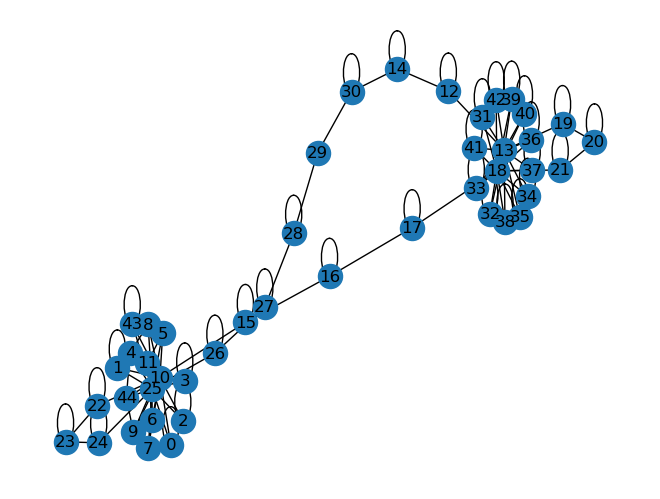

In [70]:
nx.draw(G, with_labels=True)

In [ ]:
sample = torch.load(r"E:/gnn_data/pyg_data_v2/76943_final_design_spike__incase_i_lose_the_file_.pt")

for key, value in sample:
    if 0 in value.shape:
        print(f"{key}: {value.shape}")